# scraping project for intro to data science

## improts:

In [89]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
from tkinter import *
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from sklearn.linear_model import LinearRegression, LassoCV, Lasso,Ridge, RidgeCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score

## aid functions:

In [90]:
def maximum(grades):
    m = grades[0]
    for lis in grades:
        if(lis[0]>m[0]):
            m = lis
    return m

In [91]:
def poly_gridsearch_r2(X,y):
    grades = []
    for n in range(1,10):
        for bias in [True,False]:
            for interaction in [True,False]:
                for intercept in [True,False]:
                    pre_process = PolynomialFeatures(degree=n,include_bias=bias,interaction_only=interaction)
                    X_poly = pre_process.fit_transform(X)
                    linreg = LinearRegression(fit_intercept=intercept)
                    scores = cross_val_score(linreg,X_poly,y,cv=10,scoring="r2")
                    grades.append([scores.mean(),n,bias,interaction,intercept])
    return maximum(grades)

In [70]:
def show_regresion_error(true_values, predictions):
    print("Root Mean squared error (test):",mean_squared_error(true_values, predictions, squared=False))
    print("Mean absolute error (test):",mean_absolute_error(true_values, predictions ))
    print("R2:",r2_score(true_values,predictions))

In [71]:
## returns: (r2_score,mae,rmse)
def regresion_error(true_values, predictions):
    return(r2_score(true_values,predictions),mean_absolute_error(true_values, predictions),mean_squared_error(true_values, predictions, squared=False))

In [72]:
def show_regresion_error_tuple(regresion_error_tuple):
    print("Root Mean squared error (test):",regresion_error_tuple[2])
    print("Mean absolute error (test):",regresion_error_tuple[1])
    print("R2:",regresion_error_tuple[0])

In [73]:
def zero_model(df,y_true,type_of_average):
    if("mean" in type_of_average):
        ave = df.cost.mean()
    else:
        ave = df.cost.median()
    y_pred_z = pd.Series([ave for x in range(len(df))])
    print("*zero model* rmse: ",mean_squared_error(y,y_pred_z,squared=False))
    print("*zero model* mae:",mean_absolute_error(y,y_pred_z))

## intro:

### in this project we are taking cars sales ads from the "komo" website using web-crawling. in the site all the sales add are divided into 4 car categories: private, commersial, jeeps and trucks. in every sale ad their are the following info about the cars: "price","km driven","year of prudaction" and some uninmportent info. we know that this data isn't going to yield the best results beacuase the lack of some importent features as the engine volum, if the car have manual transmission or automatic transmission, but we'll try to make the most out of it.

## scraping and cleaning the data:

### scraping the data:

In [985]:
## our target website haven't got all the sale ads in one url
## so we'll go throgh all of the urls that store the sale ads
## first we'll store them in a list:
links = []
for style in ["private","commercial","jeeps","trucks"]:
    for x in [("https://www.komo.co.il/code/cars/"+style+".asp?currPage="+y+"&subLuachNum=1&collapsed=1") for y in ["1","2","3","4","5","6","7","8","9","10"]]:
        links.append(x)

In [986]:
 ## the following code aproves that we have all the links we need:
links

['https://www.komo.co.il/code/cars/private.asp?currPage=1&subLuachNum=1&collapsed=1',
 'https://www.komo.co.il/code/cars/private.asp?currPage=2&subLuachNum=1&collapsed=1',
 'https://www.komo.co.il/code/cars/private.asp?currPage=3&subLuachNum=1&collapsed=1',
 'https://www.komo.co.il/code/cars/private.asp?currPage=4&subLuachNum=1&collapsed=1',
 'https://www.komo.co.il/code/cars/private.asp?currPage=5&subLuachNum=1&collapsed=1',
 'https://www.komo.co.il/code/cars/private.asp?currPage=6&subLuachNum=1&collapsed=1',
 'https://www.komo.co.il/code/cars/private.asp?currPage=7&subLuachNum=1&collapsed=1',
 'https://www.komo.co.il/code/cars/private.asp?currPage=8&subLuachNum=1&collapsed=1',
 'https://www.komo.co.il/code/cars/private.asp?currPage=9&subLuachNum=1&collapsed=1',
 'https://www.komo.co.il/code/cars/private.asp?currPage=10&subLuachNum=1&collapsed=1',
 'https://www.komo.co.il/code/cars/commercial.asp?currPage=1&subLuachNum=1&collapsed=1',
 'https://www.komo.co.il/code/cars/commercial.asp?

In [987]:
        ## now w'll make a list of the soup varables of the
        ## websites!
        ### note that the code below requests information from 40
        ### websites so it might take up to a minate for it to end 
        ### all the requests
soups = []
for x in links:
    page = requests.get(x)
    soup = BeautifulSoup(page.text,"html.parser")
    soups.append(soup)

In [988]:
   ## now we'll use all the soup variables to 
        ## get the data we need!
data = []
for x in soups:
    for tr in (x.findAll("tr" ,bgcolor="#FFFFFF")):
        values = [td.text for td in tr.findAll("td")]
        data.append(values)

In [989]:
## the code below approve that we have all the needed data
## and the amount of samples matches the value we expected.
## that's beacuse we took information from 40 websites 
## which on every one of them there are 20 sale ads!
## but now the website dropped a lot of the track ads... so we left with 701
## instead of 800
print(len(data))


699


In [990]:
## the code below tells us that all the details about the cars
## are stored in string varbales so we will change them to 
## int type in the foregoing
print(type(data[0][0]))
print(type(data[10][1]))
print(type(data[80][2]))
print(type(data[120][3]))
print(type(data[500][4]))
print(type(data[600][5]))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


In [991]:
## now we are turning the data list into a dataframe!
df = pd.DataFrame(data,columns=["car_type","firm","area","km","cost","year of prudaction","time of ad"])
df

,car_type,firm,area,km,cost,year of prudaction,time of ad
0,רכב פרטי,מאזדה - 3,חיפה וחוף הכרמל,141542,"34,000 ₪",2010,1 ימים
1,רכב פרטי,טויוטה - יאריס,מושבים בשרון,169000,"15,900 ₪",2007,1 ימים
2,רכב פרטי,מרצדס - E-CLASS,חיפה וחוף הכרמל,129000,"70,000 ₪",2009,1 ימים
3,רכב פרטי,קיה - פיקנטו,פתח תקוה והסביבה,55000,"67,000 ₪",2019,1 ימים
4,רכב פרטי,טויוטה - קורולה,נתניה והסביבה,180000,"10,000 ₪",2002,1 ימים
...,...,...,...,...,...,...,...
694,משאיות,וולוו - fl 250,חיפה וחוף הכרמל,500000,לא צויין,2006,0 דקות
695,משאיות,סקניה -,פתח תקוה והסביבה,500000,לא צויין,2009,0 דקות
696,משאיות,מרצדס - ארקוס,באר שבע והסביבה,390000,לא צויין,2016,1 ימים
697,משאיות,מאן - משא להובלת רכב,נתניה והסביבה,180000,לא צויין,2013,21 ימים


In [992]:
df.describe()

,car_type,firm,area,km,cost,year of prudaction,time of ad
count,699,699,699,699,699,699,699
unique,4,305,35,329,257,31,30
top,רכב פרטי,סיטרואן - ברלינגו,חיפה וחוף הכרמל,85000,לא צויין,2016,0 דקות
freq,200,20,65,11,105,75,228


### cleaning the data:
        

#### note that we saved the df ahead of time, so that all the analysis and operations that we made to it would be conssistent.

In [11]:
df = pd.read_csv("data/saved_data_before_cleaning.csv").iloc[:,1:]
print(df.shape)
df.head(2)

(701, 7)


,car_type,firm,area,km,cost,year of prudaction,time of ad
0,רכב פרטי,סוזוקי - סוויפט,בקעת אונו,167000,"24,000 ₪",2010,6 שעות
1,רכב פרטי,מאזדה - 3,חיפה וחוף הכרמל,141542,"34,000 ₪",2010,4 שעות


In [12]:
## let's see how a "cost" value looks like:
df['cost'].iloc[576]

'27,500\xa0₪'

In [13]:
# removing the crap data  
# we'll remove the rows that have NaN values in the "cost","km" and "year of prudaction" columns

df = df.dropna(subset=["cost","km","year of prudaction"])  
print(df.shape)
df.head(2) 


(701, 7)


,car_type,firm,area,km,cost,year of prudaction,time of ad
0,רכב פרטי,סוזוקי - סוויפט,בקעת אונו,167000,"24,000 ₪",2010,6 שעות
1,רכב פרטי,מאזדה - 3,חיפה וחוף הכרמל,141542,"34,000 ₪",2010,4 שעות


In [14]:
## cheking if the data have resonable values:
print("car types:",df.car_type.unique(),'\n')
print(df.car_type.value_counts(),'\n')
print("different costs of *cars*(all types):",len(df.cost.unique()),'\n')
print("different costs of *privates*:",len(df[df.car_type == "רכב פרטי"].cost.unique()),'\n')
print("different costs of *comercial*:",len(df[df.car_type == "רכב מסחרי"].cost.unique()),'\n')
print("different cost of *jeeps*:",len(df[df.car_type == "ג'יפים"].cost.unique()),'\n')
print("different cost of *trucks*:",len(df[df.car_type == "משאיות"].cost.unique()))
    ## in the code below we can see that
    ## the amount of unique cost seems resonable - there isn't too much repetition,
    ## so the data looks fine.

car types: ['רכב פרטי' 'רכב מסחרי' "ג'יפים" 'משאיות'] 

רכב פרטי     200
רכב מסחרי    200
ג'יפים       200
משאיות       101
Name: car_type, dtype: int64 

different costs of *cars*(all types): 256 

different costs of *privates*: 133 

different costs of *comercial*: 93 

different cost of *jeeps*: 134 

different cost of *trucks*: 44


In [15]:
df.describe()

,km,year of prudaction
count,701.000000,701.000000
mean,161390.564907,2013.813124
std,131158.302690,5.592408
min,0.000000,1988.000000
25%,67000.000000,2010.000000
50%,133000.000000,2015.000000
75%,220000.000000,2018.000000
max,850000.000000,2022.000000


In [16]:
## although there is alot of values for the "firm","area" columns we'll use them as a fetuare that store the model name of the car and the 
## area of the car owner. we won't delete the "firm" and "area" columns althouth they aren't clean and usable yet, but we will make them usable in the 
## "making new fetures" section. 
print(len(df.firm.unique()))
print(len(df.area.unique()))
df.firm.unique()

305
36


array(['סוזוקי - סוויפט', 'מאזדה - 3', 'טויוטה - יאריס',
       'טויוטה - קורולה', 'מרצדס - E-CLASS', 'מרצדס - S-CLASS',
       'פולקסווגן - גולף', 'יונדאי - סונטה', 'פורד - פיאסטה',
       'הונדה - סיוויק האצ’בק החדשה', 'פורד - פוקוס', 'טויוטה - ורסו',
       'סוזוקי - קרוסאובר', 'טויוטה - אוריס', 'סקודה - סופרב',
       'טויוטה - קאמרי', 'פורד - מונדאו', 'פיג’ו - 5008', 'פורד - גלאקסי',
       'פולקסווגן - פאסאט', 'יונדאי - i30cw', 'קיה - פיקנטו',
       'סקודה - ראפיד', 'קיה - אופטימה', 'פיאט - 500', 'סקודה - אוקטביה',
       'פיאט - קובו', 'אופל - אסטרה', 'הונדה - HRV', 'סיטרואן - C3',
       'יונדאי - i20', 'אאודי - 80', 'פיג’ו - 508',
       'קרייזלר - גראנד וויאג’ר', 'רנו - קופה', 'אאודי - A6', 'מאזדה - 6',
       'מיצובישי - ספייס סטאר', 'סוזוקי - ליאנה החדשה', 'טויוטה - C-HR',
       'קרייזלר - טאון קאנטרי', 'ב.מ.וו - סדרה 3', 'ב.מ.וו - סדרה 1',
       'יונדאי - ACCNET', 'יונדאי - אלנטרה', 'פיג’ו - 301',
       'פיג’ו - RCZ\t', 'הונדה - ג’אז', 'רנו - מגאן', 'רנו - סניק',
     

In [17]:
## the "time of add" column is redundent (this column notes the time the ad was on the 
## website)
## so we'll drop those two.
df = df.drop(["time of ad"],axis=1) #"firm",you can add it if this does not give you good result 
df

,car_type,firm,area,km,cost,year of prudaction
0,רכב פרטי,סוזוקי - סוויפט,בקעת אונו,167000,"24,000 ₪",2010
1,רכב פרטי,מאזדה - 3,חיפה וחוף הכרמל,141542,"34,000 ₪",2010
2,רכב פרטי,טויוטה - יאריס,מושבים בשרון,169000,"15,900 ₪",2007
3,רכב פרטי,טויוטה - קורולה,נתניה והסביבה,180000,"10,000 ₪",2002
4,רכב פרטי,מרצדס - E-CLASS,חיפה וחוף הכרמל,129000,"70,000 ₪",2009
...,...,...,...,...,...,...
696,משאיות,מאן - משא להובלת רכב,נתניה והסביבה,180000,לא צויין,2013
697,משאיות,מאן -,"ראשל""צ והסביבה",280000,לא צויין,2006
698,משאיות,אינטרנשיונל - דו שימושי,אילת והערבה,2000,לא צויין,2020
699,משאיות,וולוו - נתמך וילון קירור 13.60,גליל ועמקים,1000,לא צויין,2010


In [18]:
## we'll make sure there isn't null values: 
df.isnull().sum()

car_type              0
firm                  0
area                  0
km                    0
cost                  0
year of prudaction    0
dtype: int64

In [19]:
## there is no null values but yet not all of the "cost" values
## are numbers that's beacause some sellers didn't mention the
## price of the vechile.
## now we'll delete the rows where the sale ad didn't 
## had a price
df = df[df.cost != "לא צויין"]
df

,car_type,firm,area,km,cost,year of prudaction
0,רכב פרטי,סוזוקי - סוויפט,בקעת אונו,167000,"24,000 ₪",2010
1,רכב פרטי,מאזדה - 3,חיפה וחוף הכרמל,141542,"34,000 ₪",2010
2,רכב פרטי,טויוטה - יאריס,מושבים בשרון,169000,"15,900 ₪",2007
3,רכב פרטי,טויוטה - קורולה,נתניה והסביבה,180000,"10,000 ₪",2002
4,רכב פרטי,מרצדס - E-CLASS,חיפה וחוף הכרמל,129000,"70,000 ₪",2009
...,...,...,...,...,...,...
686,משאיות,דאף - 55,באר שבע והסביבה,500000,"110,000 ₪",2015
687,משאיות,רנו - מאטר,מושבים בצפון,85000,"80,000 ₪",2018
688,משאיות,דאף - 55,אשדוד - אשקלון,313000,"50,000 ₪",2001
689,משאיות,איסוזו - ספורט/כביש,מושבים בשרון,4545,"39,000 ₪",2018


In [20]:
## now we'll make a function that can turn
## "cost" column (which are of type string)
## to an int type
to_cost = lambda x:int(x[0:-2].replace(",",""))
to_int = lambda x : int(x)
df.cost = df.cost.apply(to_cost)
df.km = df.km.apply(to_int)
df["year of prudaction"] = df["year of prudaction"].apply(to_int)
df.head(2)

C:\Users\noams\anaconda3\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\noams\AppData\Local\Temp/ipykernel_21200/555555719.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["year of prudaction"] = df["year of prudaction"].apply(to_int)


,car_type,firm,area,km,cost,year of prudaction
0,רכב פרטי,סוזוקי - סוויפט,בקעת אונו,167000,24000,2010
1,רכב פרטי,מאזדה - 3,חיפה וחוף הכרמל,141542,34000,2010


In [21]:
## cheking if the type of the columns "km","cost" and "year of prudaction" have changed to int:
print(type(df.km[0]))
print(type(df.cost[0]))
print(type(df["year of prudaction"][0]))

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


In [22]:
## note that the "car_type" column is a string column that have
## 4 possible values: "רכב פרטי","רכב מסחרי","גיפים","משאיות"
## we can't use this column as a feature just yet beacuase it's
## a string, we could decide that רכב פרטי=1, רכב מסחרי=2, גיפים=3, but if
## we'll do so we'll create a bias for the model that "רכב פרטי" is somehow more "closer"
## to "רכב מסחרי" from "גיפים", which we don't want so we'll use dummy variables insted:
type_dummies = pd.get_dummies(df.car_type).iloc[:,1:]
df = pd.concat([df,type_dummies], axis = 1)
df

,car_type,firm,area,km,cost,year of prudaction,משאיות,רכב מסחרי,רכב פרטי
0,רכב פרטי,סוזוקי - סוויפט,בקעת אונו,167000,24000,2010,0,0,1
1,רכב פרטי,מאזדה - 3,חיפה וחוף הכרמל,141542,34000,2010,0,0,1
2,רכב פרטי,טויוטה - יאריס,מושבים בשרון,169000,15900,2007,0,0,1
3,רכב פרטי,טויוטה - קורולה,נתניה והסביבה,180000,10000,2002,0,0,1
4,רכב פרטי,מרצדס - E-CLASS,חיפה וחוף הכרמל,129000,70000,2009,0,0,1
...,...,...,...,...,...,...,...,...,...
686,משאיות,דאף - 55,באר שבע והסביבה,500000,110000,2015,1,0,0
687,משאיות,רנו - מאטר,מושבים בצפון,85000,80000,2018,1,0,0
688,משאיות,דאף - 55,אשדוד - אשקלון,313000,50000,2001,1,0,0
689,משאיות,איסוזו - ספורט/כביש,מושבים בשרון,4545,39000,2018,1,0,0


In [23]:
## we'll rename the variables to english
## and drop the "car_type" column since
## we don't need it anymore
df = df.rename(columns={"רכב פרטי":"private","רכב מסחרי":"commercial","משאיות":"tracks"})
df = df.drop(columns={"car_type"}) 
df

,firm,area,km,cost,year of prudaction,tracks,commercial,private
0,סוזוקי - סוויפט,בקעת אונו,167000,24000,2010,0,0,1
1,מאזדה - 3,חיפה וחוף הכרמל,141542,34000,2010,0,0,1
2,טויוטה - יאריס,מושבים בשרון,169000,15900,2007,0,0,1
3,טויוטה - קורולה,נתניה והסביבה,180000,10000,2002,0,0,1
4,מרצדס - E-CLASS,חיפה וחוף הכרמל,129000,70000,2009,0,0,1
...,...,...,...,...,...,...,...,...
686,דאף - 55,באר שבע והסביבה,500000,110000,2015,1,0,0
687,רנו - מאטר,מושבים בצפון,85000,80000,2018,1,0,0
688,דאף - 55,אשדוד - אשקלון,313000,50000,2001,1,0,0
689,איסוזו - ספורט/כביש,מושבים בשרון,4545,39000,2018,1,0,0


In [24]:
df.head(2)

,firm,area,km,cost,year of prudaction,tracks,commercial,private
0,סוזוקי - סוויפט,בקעת אונו,167000,24000,2010,0,0,1
1,מאזדה - 3,חיפה וחוף הכרמל,141542,34000,2010,0,0,1


In [25]:
df.describe()

,km,cost,year of prudaction,tracks,commercial,private
count,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000
mean,153464.063758,78909.243289,2013.879195,0.112416,0.270134,0.317114
std,122978.603897,60915.179729,5.593709,0.316143,0.444402,0.465743
min,70.000000,1000.000000,1988.000000,0.000000,0.000000,0.000000
25%,66750.000000,31375.000000,2010.000000,0.000000,0.000000,0.000000
50%,128000.000000,67000.000000,2015.000000,0.000000,0.000000,0.000000
75%,204000.000000,110000.000000,2018.000000,0.000000,1.000000,1.000000
max,630000.000000,475000.000000,2022.000000,1.000000,1.000000,1.000000


In [26]:
## making "cost" the first column for comfort
df = df[["cost","km","year of prudaction","firm","area","tracks","commercial","private"]]

### removing outliers:

array([[<AxesSubplot:title={'center':'cost'}>,
        <AxesSubplot:title={'center':'km'}>],
       [<AxesSubplot:title={'center':'year of prudaction'}>,
        <AxesSubplot:title={'center':'tracks'}>],
       [<AxesSubplot:title={'center':'commercial'}>,
        <AxesSubplot:title={'center':'private'}>]], dtype=object)

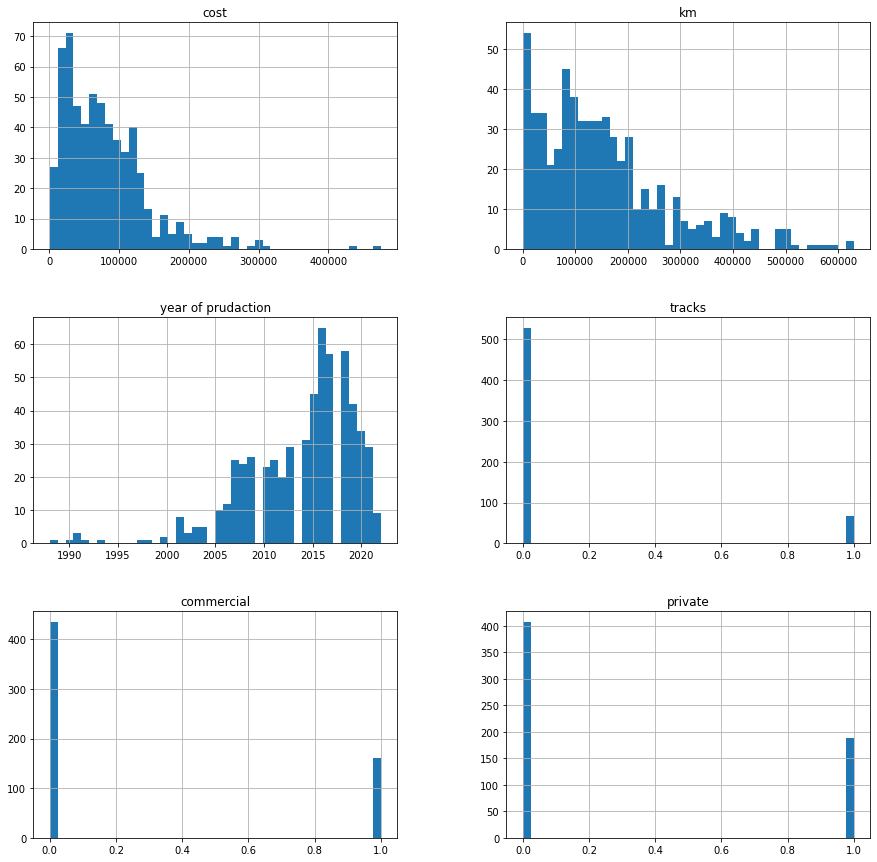

In [27]:
df.hist(figsize=(15,15),bins=42)

<AxesSubplot:>

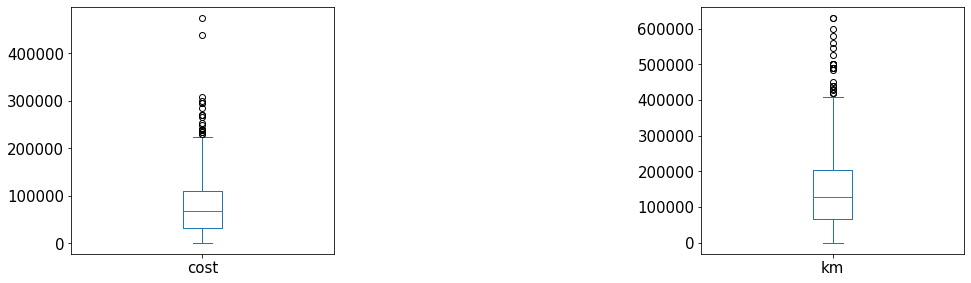

In [28]:
plt.subplot(2,3,1)
df.cost.plot(kind = "box",figsize=(15,10),fontsize=15)
plt.subplot(2,3,3)
df.km.plot(kind = "box",figsize =(16,10),fontsize=15)

In [29]:
## we can see that there is alot of outliers in the "cost" and "km" columns.

#### Applying Interquartile Range method(IQR) for the removal of outliers.

In [30]:
cols = ['cost', 'km'] 

Q1 = df[cols].quantile(0.25) # 25th percentile  
Q3 = df[cols].quantile(0.75) # 75th percentile  
IQR = Q3 - Q1 # the value diffrence between the 75th and 25th percentile is the Inter-quartile range

In [31]:
df = df[~((df[cols] < (Q1 - 1.5 * IQR)) | (df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)] # remove outliers using IQR method

In [32]:
df.describe()

,cost,km,year of prudaction,tracks,commercial,private
count,550.000000,550.000000,550.00000,550.000000,550.000000,550.000000
mean,72088.016364,140040.930909,2013.96000,0.094545,0.261818,0.341818
std,46903.969282,98882.273124,5.45542,0.292852,0.440024,0.474751
min,1000.000000,211.000000,1988.00000,0.000000,0.000000,0.000000
25%,30000.000000,67325.000000,2011.00000,0.000000,0.000000,0.000000
50%,67000.000000,126500.000000,2015.00000,0.000000,0.000000,0.000000
75%,105000.000000,195750.000000,2018.00000,0.000000,1.000000,1.000000
max,224580.000000,407000.000000,2022.00000,1.000000,1.000000,1.000000


<AxesSubplot:>

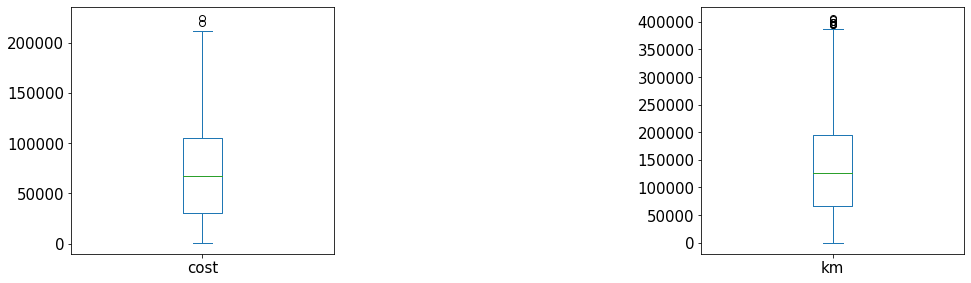

In [33]:
plt.subplot(2,3,1)
df.cost.plot(kind = "box",figsize=(15,10),fontsize=15)
plt.subplot(2,3,3)
df.km.plot(kind = "box",figsize =(16,10),fontsize=15)

array([[<AxesSubplot:title={'center':'cost'}>,
        <AxesSubplot:title={'center':'km'}>],
       [<AxesSubplot:title={'center':'year of prudaction'}>,
        <AxesSubplot:title={'center':'tracks'}>],
       [<AxesSubplot:title={'center':'commercial'}>,
        <AxesSubplot:title={'center':'private'}>]], dtype=object)

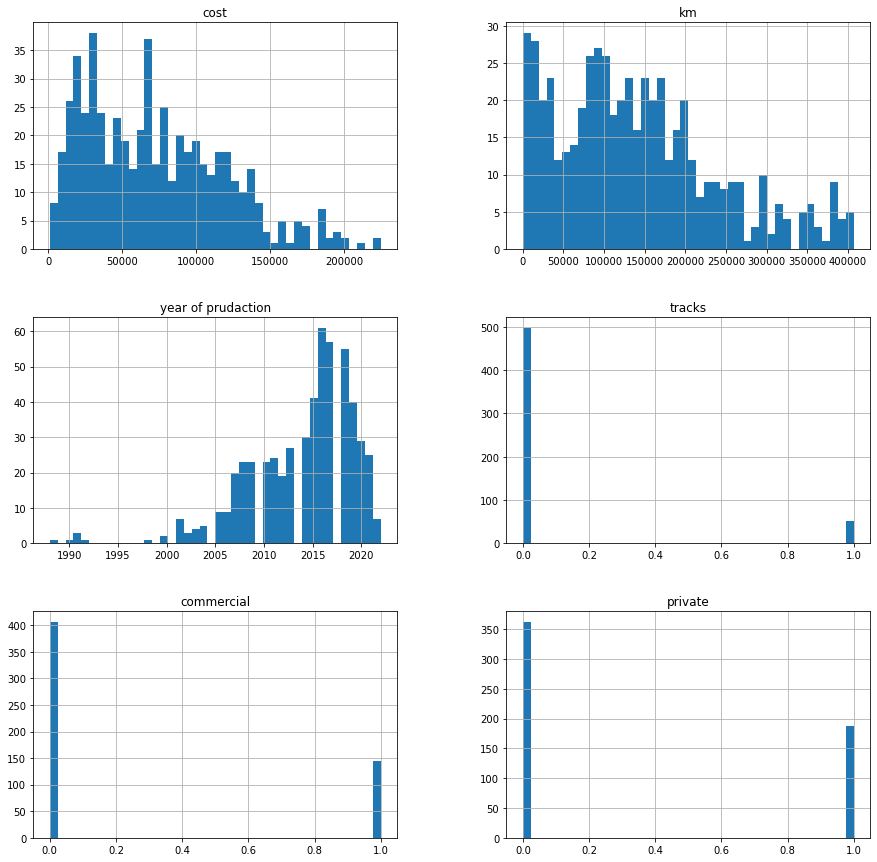

In [34]:
df.hist(figsize=(15,15),bins=42)

In [35]:
## we can see that the outliers have been removed.

## making new fetures

In [36]:
## right now we can't use the "area" column as a feature beacause it's of type string.
## lets see if we divide this column into dummy variables:
df.area.unique()

array(['בקעת אונו', 'חיפה וחוף הכרמל', 'מושבים בשרון', 'נתניה והסביבה',
       'קריות', 'אשדוד - אשקלון', 'בית שמש והסביבה', 'רמלה - לוד',
       'ראשל"צ והסביבה', 'פתח תקוה והסביבה', 'רמת גן - גבעתיים',
       'ירושלים והסביבה', 'חדרה וישובי עמק חפר', 'מושבים בצפון',
       'באר שבע והסביבה', 'גליל ועמקים', 'תל אביב', 'מודיעין והסביבה',
       'נס ציונה - רחובות', 'רמת השרון - הרצליה', 'עמק יזרעאל',
       'מושבים בדרום', 'חולון - בת ים', 'גדרה יבנה והסביבה',
       'עכו - נהריה', 'רעננה - כפר סבא', 'אילת והערבה', 'יישובי השומרון',
       'הוד השרון והסביבה', 'מושבים בשפלה', 'זכרון - בנימינה',
       'טבריה והסביבה', 'אזור צפון', 'קיסריה והסביבה', 'אזור דרום'],
      dtype=object)

In [37]:
#     we can see in the cell above that there is too much diffrent values in "area" column
#     so we can't divie it to dummiy variables, but we can encode then in label encoding
#     in the same column: "area" column, using "LabelEncoder" lybriy will give each "area"
#     a number and will use this as a feture

### Encoding categorical columns so that they could be used in model training.

In [38]:
from sklearn.preprocessing import LabelEncoder    
le = LabelEncoder()  
df.area = le.fit_transform(df.area)
df.firm = le.fit_transform(df.firm)  # fit the encoder and transform the labels   
df.head()

,cost,km,year of prudaction,firm,area,tracks,commercial,private
0,24000,167000,2010,139,6,0,0,1
1,34000,141542,2010,88,13,0,0,1
2,15900,169000,2007,63,21,0,0,1
3,10000,180000,2002,66,23,0,0,1
4,70000,129000,2009,110,13,0,0,1


In [40]:
df.area.unique()

array([ 6, 13, 21, 23, 28,  3,  5, 30, 29, 26, 31, 16, 11, 19,  4,  8, 34,
       17, 22, 32, 25, 18, 12,  7, 24, 33,  2, 15,  9, 20, 10, 14,  1, 27,
        0])

## visualizing the data:

array([[<AxesSubplot:title={'center':'cost'}>,
        <AxesSubplot:title={'center':'km'}>,
        <AxesSubplot:title={'center':'year of prudaction'}>],
       [<AxesSubplot:title={'center':'firm'}>,
        <AxesSubplot:title={'center':'area'}>,
        <AxesSubplot:title={'center':'tracks'}>],
       [<AxesSubplot:title={'center':'commercial'}>,
        <AxesSubplot:title={'center':'private'}>, <AxesSubplot:>]],
      dtype=object)

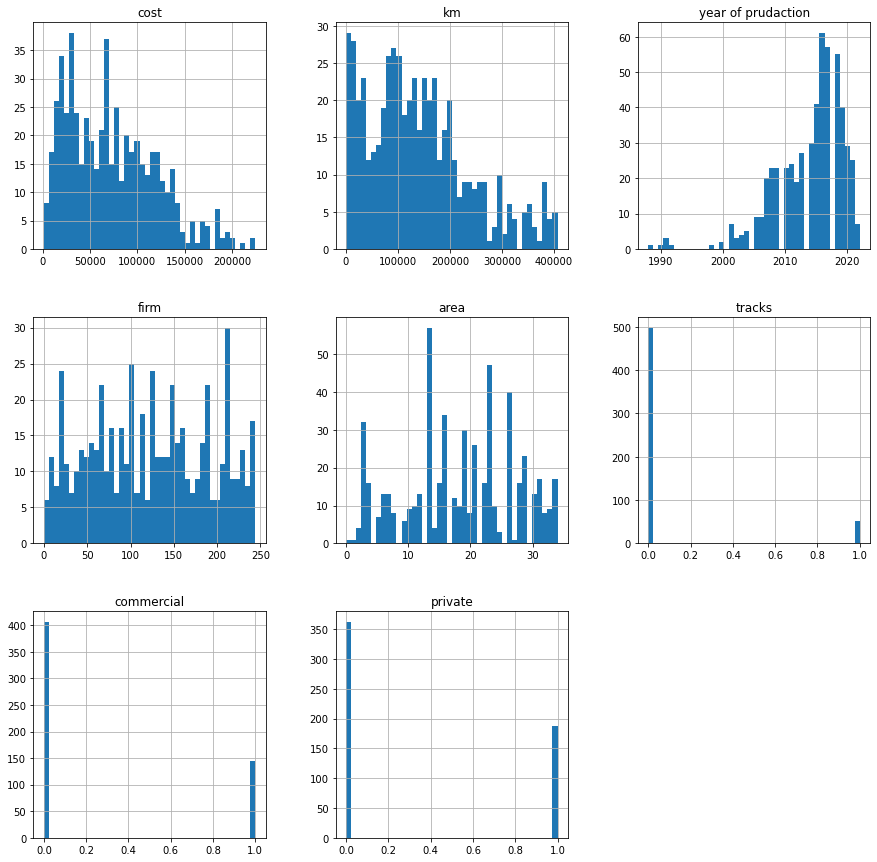

In [41]:
## let's start visulazie the data: 
df.hist(figsize=(15,15),bins=42)

In [42]:
## we saw that before the removal of the outliers the data distrebution looked really diffrent

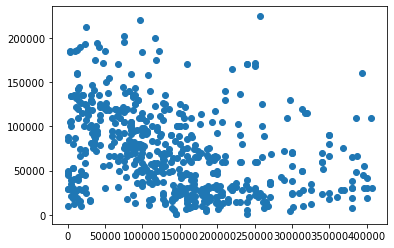

In [43]:
## now lets see the connection beatween the features and the target:
import matplotlib.pyplot as plt
plt.plot(df["km"],df.cost,"o")

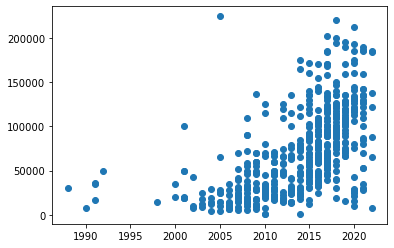

In [44]:
plt.plot(df["year of prudaction"],df.cost,"o")

In [45]:
## it's seems that the relation between the "year of prudacion" and the "cost" is roghtlly of second power,
## and that the relation between "km" and "cost" is more complcated then a linear relation
## so polynomial reggretion should bring better results then linear reggretion.
## but we'll also use more advaned techniques as gradient boosting and adaptive boosting.

In [46]:
df.corr() 

,cost,km,year of prudaction,firm,area,tracks,commercial,private
cost,1.000000,-0.336571,0.564274,-0.015568,-0.000019,-0.128075,-0.027057,-0.205690
km,-0.336571,1.000000,-0.554317,0.005398,0.026548,-0.008485,0.346961,-0.144449
year of prudaction,0.564274,-0.554317,1.000000,0.107099,0.019016,-0.027272,-0.139800,0.020058
firm,-0.015568,0.005398,0.107099,1.000000,0.076717,-0.216349,0.151608,0.014893
area,-0.000019,0.026548,0.019016,0.076717,1.000000,-0.112103,0.067528,0.056838
tracks,-0.128075,-0.008485,-0.027272,-0.216349,-0.112103,1.000000,-0.192444,-0.232869
commercial,-0.027057,0.346961,-0.139800,0.151608,0.067528,-0.192444,1.000000,-0.429183
private,-0.205690,-0.144449,0.020058,0.014893,0.056838,-0.232869,-0.429183,1.000000


### After checking correlation matrix, we realised that 'year of prudaction' is our best feature, as it has the highest correlation score among all features.

In [47]:
# df.to_csv("data/new_saved_data.csv")

## Finding the best model:

In [102]:
## note that we saved the model erlier:
df = pd.read_csv("data/saved_data_after_cleaning.csv").iloc[:,1:]
print(df.shape)
df.head(2)

(548, 8)


,firm,area,km,cost,year of prudaction,tracks,commercial,private
0,65,23,180000,10000,2002,0,0,1
1,109,13,129000,70000,2009,0,0,1


In [103]:
## spliting data into taget and features:
X = df.drop(['cost'], axis = 1) 
y = df.cost 

### Applying Linear Regression method and checking the score we get

In [104]:
## training linear reggretion model:  
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)
linreg = LinearRegression().fit(X_train,y_train)
y_pred = linreg.predict(X_test)
show_regresion_error(y_test,y_pred)

normal_linreg_r2 = r2_score(y_test,y_pred)
# 2.5 seconds to run

Root Mean squared error (test): 33962.29953731215
Mean absolute error (test): 25532.528660988013
R2: 0.486518115354019


### Applying Random Forest Regressor method and checking the score we get

In [105]:
from sklearn.ensemble import RandomForestRegressor   # 1.3 seconds
rf = RandomForestRegressor()   
rf.fit(X_train,y_train)   
rf_pred = rf.predict(X_test)     
print(f'Accuracy of Rf:{r2_score(y_test,rf_pred)*100}%')


Accuracy of Rf:65.20944298303309%


### Applying Gradient Boosting Regressor method and checking the score we get

In [106]:
from sklearn.ensemble import GradientBoostingRegressor   # 0.6 seconds
gbr = GradientBoostingRegressor()
gbr.fit(X_train,y_train)   
gbr_pred = gbr.predict(X_test)  
print(f'Accuracy of GBR:{r2_score(y_test,gbr_pred)*100}%') 

Accuracy of GBR:68.65813692966327%


### Applying XGBoost Regressor method and checking the score we get

In [107]:
from xgboost import XGBRegressor  # 2.4 seconds
xgb = XGBRegressor()  
xgb.fit(X_train,y_train)   
xgb_pred = xgb.predict(X_test)  
print(f'Accuracy of XGB:{r2_score(y_test,xgb_pred)*100}%') 

Accuracy of XGB:68.55099974894785%


### Applying Ada-boost Regressor method and checking the score we get

In [108]:
from sklearn.ensemble import AdaBoostRegressor  # 0.4 seconds
abr = AdaBoostRegressor()
abr.fit(X_train,y_train)
abr_pred = abr.predict(X_test)  
print(f'Accuracy of ABR:{r2_score(y_test,abr_pred)*100}%') 

Accuracy of ABR:47.98875791102196%


### Applying Voting Regressor method and checking the score we get

In [109]:
from sklearn.ensemble import VotingRegressor  
vr = VotingRegressor(estimators=[('lr', linreg), ('rf', rf), ('gbr', gbr), ('xgb', xgb), ('abr', abr)])
vr.fit(X_train,y_train)
vr_pred = vr.predict(X_test)
print(f'Accuracy of VR:{r2_score(y_test,vr_pred)*100}%')  

Accuracy of VR:68.13405716069668%


### Applying Stacking Regressor method and checking the score we get

In [110]:
from sklearn.ensemble import StackingRegressor  #7.9 seconds
sr = StackingRegressor(estimators=[('lr', linreg), ('rf', rf), ('gbr', gbr), ('xgb', xgb), ('abr', abr)])
                            
sr.fit(X_train,y_train)  
sr_pred = sr.predict(X_test)
print(f'Accuracy of SR:{r2_score(y_test,sr_pred)*100}%')  



Accuracy of SR:70.67497350109963%


In [113]:
## saving the stacking regressor scores:
sr_regression_error = regresion_error(y_test,sr_pred)

In [114]:
## finding the best polynomial regression:
## takes up to 20 seconds
b_grade = poly_gridsearch_r2(X,y)
print(b_grade)
normal_poly_r2_ave = b_grade[0]

[0.2665506589920639, 2, False, False, True]


In [115]:
## implementing the best polynomial regretion.
pre_process = PolynomialFeatures(degree=b_grade[1],include_bias=b_grade[2],interaction_only=b_grade[3])
X_poly = pre_process.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_poly,y,random_state=1)

linreg = LinearRegression(fit_intercept=b_grade[4])
linreg.fit(X_train,y_train)
y_pred = linreg.predict(X_test)  
show_regresion_error(y_test,y_pred)

best_poly_regresion_error = regresion_error(y_test,y_pred)

Root Mean squared error (test): 31149.013223557162
Mean absolute error (test): 22250.601228840158
R2: 0.5680638661291904


## compering to "zero model" and summary:

### to sum up we made a model that uses little information about vehicles ("km","year of prudaction","area","model") and made much more accurate model then the last one beacause we saw some pattern in the naming of the models of the cars and used the "area" as a feature. we managed to evoid feature overfiting and made better models then the last project with ensamble techniques.

In [116]:
## showing the end results:
print("optimized poly regression:")
show_regresion_error_tuple(best_poly_regresion_error)
print()
print("stacking regressor:")
show_regresion_error_tuple(sr_regression_error)
print()
zero_model(df,y,"mean")

optimized poly regression:
Root Mean squared error (test): 31149.013223557162
Mean absolute error (test): 22250.601228840158
R2: 0.5680638661291904

stacking regressor:
Root Mean squared error (test): 25665.736507709174
Mean absolute error (test): 18390.02448985094
R2: 0.7067497350109964

*zero model* rmse:  46874.19385669495
*zero model* mae: 38634.94391683095
